<h1><p><strong>Where did you get the data ?</strong> <strong></strong></p></h1>

In [37]:
%%html
<table cellspacing='2'>
<td> <a href="https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia/home">link to kaggle dataset</a> <p>&nbsp;</p></td>
    <tr>   
    <td> <img src="./pics/2class_pneumonia.jpg" alt="image" style="width: 1000px;"/> </td>
    </tr>
</table>

""


------------------------------------------------------------------------------------------------------------------------------

<h1><p><strong>  Let's start building a model that can do the task</strong></p></h1><h2><strong><em>=>learn the label(=Pneumonia/Normal) per given x-ray image</em></strong></h2>

## Step 1. Load pre-processed dataset 

In [2]:
# to install Conx package go to https://github.com/Calysto/conx
# https://github.com/Calysto/conx-notebooks/tree/master/HowToRun#how-to-run-conx
# exercise for all deep learning : https://github.com/Calysto/conx-notebooks
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread
### load dataset 

X=np.load('X.npy')
y=np.load('Y.npy')
X.shape, y.shape

((100, 150, 150, 3), (100,))

## Step 2. Exploration - understanding features 

number  75
---------------- manipulate the image morphology -------------


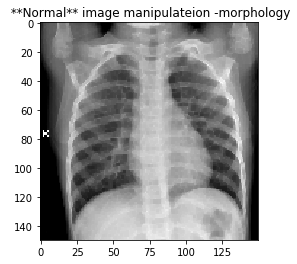

------------ find dominate gray-scale color in **Normal** x-ray image ------------
color range start :0 end : 115.25333333333333 
color range start :115.25333333333333 end : 241.32 
color range start :241.32 end : 300.0 


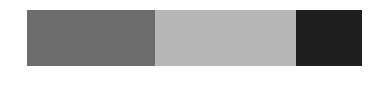

---------- find rib cage within the **Normal** image ---------


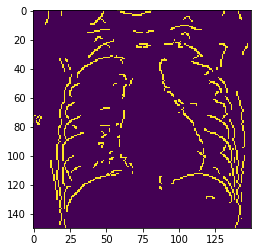

-------- find rib cage transparency within the x-ray image ------


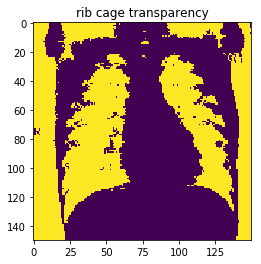

-------- find background areas ------


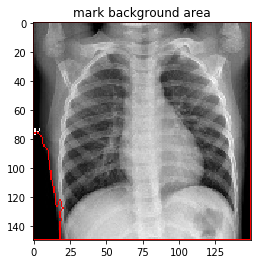

In [43]:
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt
import findcolor
%matplotlib inline
#rnn=random.randint(0,99)
# normal 75
# 32 pneumonia 
rnn=random.choice([75,32])
print("number ",str(rnn))
classes={1:'Pneumonia',0:'Normal'}
#sample_img=X[rnn]

sample_img=X[rnn]
#print ("---------------- original image **{}** -------------".format(y[rnn]))
#plt.imshow(sample_img)
#plt.title("sample image")
#plt.show()
"""
#print(sample_img.shape)
# Creating our 3 x 3 kernel
kernel_3x3 = np.ones((3, 3), np.float32) / 9

# We use the cv2.fitler2D to conovlve the kernal with an image 
blurred = cv2.filter2D(sample_img, -1, kernel_3x3)
#cv2.imshow('3x3 Kernel Blurring', blurred)
#cv2.waitKey(0)
#print(blurred.shape)
print("----------------- blur the image ----------------- ")
plt.imshow(blurred)
plt.title("image manipulation - blurred")
plt.show()

print("----------------- rotate and shrink the image ----------------- ")
### rotate image
height, width = sample_img.shape[:2]
# Divide by two to rototate the image around its centre
rotation_matrix = cv2.getRotationMatrix2D((width/2, height/2), 30, .5)
rotated_image = cv2.warpAffine(sample_img, rotation_matrix, (width, height))
plt.imshow(rotated_image)
plt.title("image manipulation - rotate&shrink")
plt.show()
"""
print ("---------------- manipulate the image morphology -------------")

kernel = np.ones((2,2), np.uint8)
"""
# Now we erode
erosion = cv2.erode(sample_img, kernel, iterations = 1)
plt.imshow(erosion)
plt.title("image manipulateion -erosion")
plt.show()

dilation = cv2.dilate(sample_img, kernel, iterations = 1)
plt.imshow(dilation)
plt.title("image manipulateion -dilation")
plt.show()
"""
closing = cv2.morphologyEx(sample_img, cv2.MORPH_CLOSE, kernel)
plt.imshow(closing)
plt.title(" **{}** image manipulateion -morphology".format(classes[y[rnn]]))
plt.show()


plt.imsave('colors.jpg', np.squeeze(sample_img))
## find top 3 dominant color in a given image
print("------------ find dominate gray-scale color in **{}** x-ray image ------------".format(classes[y[rnn]]))
findcolor.find_color('colors.jpg')

im=cv2.imread('colors.jpg')

# Find Canny edges
edged = cv2.Canny(np.squeeze(sample_img), 197, 255)
#print(edged.shape)
img, contours, _ = cv2.findContours(edged, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
# Sort contours smallest to largest using reverse=False
sorted_contours = sorted(contours, key=cv2.contourArea, reverse=False) 
print("---------- find rib cage within the **{}** image ---------".format(classes[y[rnn]]))

cv2.drawContours(img, sorted_contours[0], -1, (0,255,0), 3)
plt.imshow(img)
plt.show()

print("-------- find rib cage transparency within the x-ray image ------")
im = cv2.imread('colors.jpg')
gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
plt.imshow(thresh)
plt.title('rib cage transparency')
plt.show()

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)
# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
#plt.imshow(sure_fg)
#plt.show()

# Marker labelling
print("-------- find background areas ------")
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(im,markers)
im[markers == -1] = [255,0,0]
plt.imshow(im)
plt.title("mark background area")
plt.show()
color_matters=False

if color_matters:
    print("------------------------  color manipulation filter red, green , blue channels ------------------ ")
    #### # Set global parameters
    RED = 0
    GREEN = 1
    BLUE = 2

    # Load the image
    img_color = cv2.imread("colors.jpg", flags=cv2.IMREAD_COLOR)
    print(img_color.shape)
    # Filter the image by desired color
    img_red = np.asarray([y[RED] for x in img_color for y in x]).reshape((img_color.shape[:2]))
    img_green= np.asarray([y[GREEN] for x in img_color for y in x]).reshape((img_color.shape[:2]))
    img_blue= np.asarray([y[BLUE] for x in img_color for y in x]).reshape((img_color.shape[:2]))
    f = plt.figure(figsize=(20,20))
    f.add_subplot(1,4, 1)
    plt.imshow(img_color)
    plt.title("contrast_img")
    f.add_subplot(1,4, 2)
    plt.imshow(img_red)
    plt.title("color_filter_red")
    f.add_subplot(1,4, 3)
    plt.imshow(img_green)
    plt.title("color_filter_green")
    f.add_subplot(1,4,4 )
    plt.imshow(img_blue)
    plt.title("color_filter_blue")
    plt.show()

## Step 3. Choose a model Architecture -> CNN

In [4]:
#build the model
import conx as cx
net = cx.Network("CNN")
base_depth = 8

Using TensorFlow backend.
ConX, version 3.7.4


In [5]:
# some initial params
tile_size=(150,150)
base_depth = 8
### build the network
net.add(cx.ImageLayer("input", tile_size, 3))
c2 = lambda i, j, act = "relu": cx.Conv2DLayer("conv_{}".format(i, j), j, (3, 3), padding='same', activation=act)
net.add(c2(0, base_depth))
net.add(c2(1, base_depth))
net.add(cx.MaxPool2DLayer("pool1", pool_size=(3, 3), dropout=0.25))
net.add(c2(2, 2*base_depth))
net.add(c2(3, 2*base_depth))
net.add(cx.MaxPool2DLayer("pool2", pool_size=(3, 3), dropout=0.25))
net.add(c2(4, 3*base_depth))
net.add(c2(5, 3*base_depth))
net.add(cx.MaxPool2DLayer("pool3", pool_size=(3, 3), dropout=0.25))
net.add(cx.FlattenLayer('flat_input'))
net.add(cx.Layer('hidden1', 300, activation='relu'))
net.add(cx.Layer('hidden2', 128, activation='relu'))
net.add(cx.Layer('output', 1, activation='sigmoid'))

'output'

In [6]:
#### making connection
net.connect('input', 'conv_0')
net.connect('conv_0', 'conv_1')
net.connect('conv_1', 'pool1')
net.connect('pool1', 'conv_2')
net.connect('conv_2', 'conv_3')
net.connect('conv_3', 'pool2')
net.connect('pool2', 'conv_4')
net.connect('conv_4', 'conv_5')
net.connect('conv_5', 'pool3')
net.connect('pool3', 'flat_input')
net.connect('flat_input', 'hidden1')
net.connect('hidden1', 'hidden2')
net.connect('hidden2', 'output')

In [7]:
net.compile(error="binary_crossentropy", optimizer="adam")

         but not using the 'softmax' activation function on layer 'output'


In [8]:
# load the pre-trained model
net.load('saved_model')

         but not using the 'softmax' activation function on layer 'output'


<IPython.core.display.Javascript object>


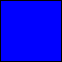
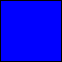
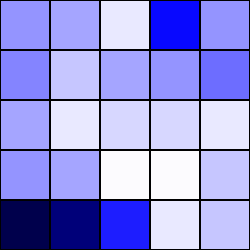
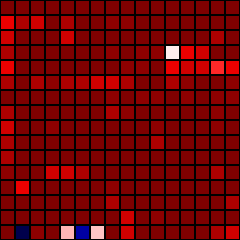
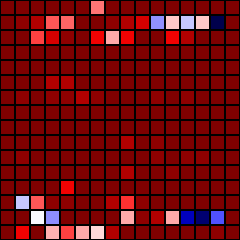
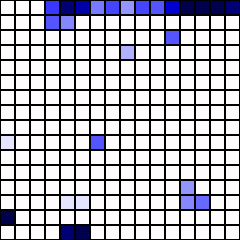
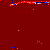
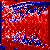
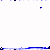
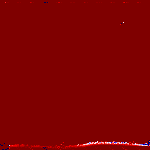
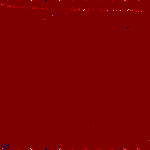
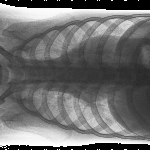

In [9]:
net.picture(X[rnn], dynamic = True, rotate = True, show_targets = True, scale = 1.25)

In [10]:
net.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 150, 150, 3)       0         
_________________________________________________________________
conv_0 (Conv2D)              (None, 150, 150, 8)       224       
_________________________________________________________________
conv_1 (Conv2D)              (None, 150, 150, 8)       584       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 8)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 8)         0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 50, 50, 16)        1168      
_________________________________________________________________
conv_3 (Conv2D)              (None, 50, 50, 16)        2320      
__________

## Step 4. Split dataset into Train vs Validation sets to train and evaluate the model respectively. 

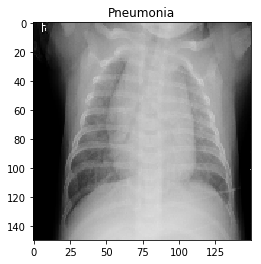

In [11]:
### randomly shuffle the data
import numpy as np
from itertools import permutations
import random
ls=[i for i in range(len(y))]
idxes=random.shuffle(ls)
ip_pairs=[(X[i],y[i].reshape(1)) for i in ls]
plt.imshow(ip_pairs[0][0])
plt.title(classes[int(ip_pairs[0][1])])
plt.show()


In [12]:
# makeing sure the classes is balanced
np.unique(y, return_counts=True)

(array([0, 1]), array([50, 50], dtype=int64))

In [13]:
net.dataset.clear()

net.dataset.append(ip_pairs)
net.dataset.split(0.25) # split into training set 75% and validataion set 25%

## Step 5. Evaluate the model result

In [14]:

net.train(epochs=45, record=True, shuffle=True, batch_size=10, accuracy=0.95)

Evaluating initial validation metrics...
No training required: accuracy already to desired value
Training dataset status:
       |  Training |  Training |  Validate |  Validate 
Epochs |     Error |  Accuracy |     Error |  Accuracy 
------ | --------- | --------- | --------- | --------- 
#   44 |   0.04637 |   0.96000 |   0.27108 |   0.88000 


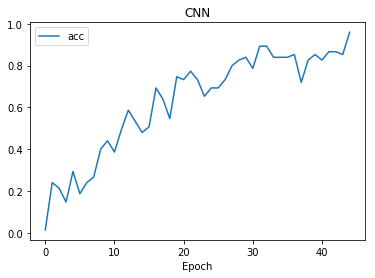

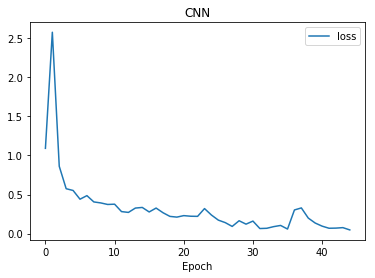

(None, None)

In [15]:
net.plot('acc'), net.plot('loss') 

In [16]:
net.evaluate()

{'acc': 0.94666667064030963,
 'loss': 0.095056302547454841,
 'val_acc': 0.87999999523162842,
 'val_loss': 0.048257708549499512}


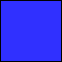
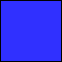
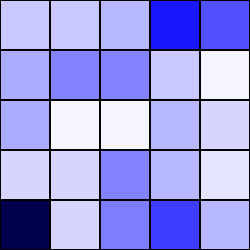
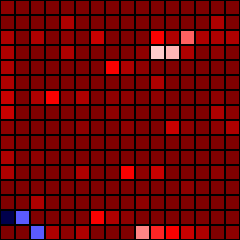
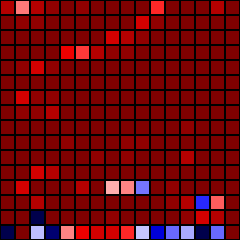
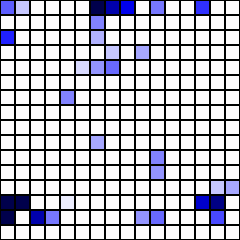
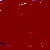
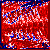
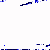
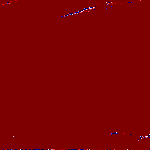
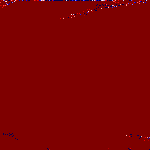
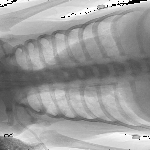

In [17]:
net.picture(X[0], dynamic = True, rotate = True, show_targets = True,class_id=1, scale =1.25)

In [36]:
net.dashboard(play_rate=0.01)

Dashboard(children=(Accordion(children=(HBox(children=(VBox(children=(Select(description='Dataset:', index=1, …

-------------------------------------------------------------------------------------------------------------------------------

<h1><p><strong>How to take this model to production </strong></p></h1><h2> <strong>Azure databrick architecture</strong></h2>

In [19]:
%%html
<table cellspacing='2'>
<td> <a href="https://www.linkedin.com/pulse/transfer-learning-azure-databrick-deploy-web-service-zenodia-charpy">how to deploy model to Azure</a> <p>&nbsp;</p></td>
    <tr>   
    <td> <img src="./pics/azure_databrick.jpg" alt="image" style="width: 1000px;"/> </td>
    </tr>
</table>

""
